In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import copy
import itertools
import numpy as np
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

In [3]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(6, 6), dpi=300)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens) #interpolation='nearest'
#     plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color, fontsize=13)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'Confusion matrix_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}', dpi=300, bbox_inches = "tight")
    plt.show()
    return figure

In [4]:
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

device = '0' #int or str
seed = 1116
pl.seed_everything(seed)
num_epochs = 50
batch_size = 256
# lr = 1e-3
# weight_decay = 1e-1
num_workers = 10

In [5]:
dataset = datasets.ImageFolder(root='./lib/data', transform=data_transforms)
total_classes = dict(Counter(dataset.targets))

train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size= .2, stratify=dataset.targets, random_state=seed)
train_indices, valid_indices = train_test_split(train_indices, test_size = .2, stratify=[dataset.targets[t] for t in train_indices], random_state=seed)

train_classes = [dataset.targets[i] for i in train_indices]
valid_classes = [dataset.targets[i] for i in valid_indices]
test_classes = [dataset.targets[i] for i in test_indices]
test_names = [dataset.imgs[i] for i in test_indices]

train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)
test_dataset = Subset(dataset, test_indices)

print('-' * 20)
print(f'Total images: {len(dataset)}')
print(total_classes)
print('-' * 20)
print(f'Training images: {len(train_dataset)} | Validation images: {len(valid_dataset)} | Testing images : {len(test_dataset)}')
print('-' * 20)
print(f'Training')
print(dict(Counter(train_classes)))
print('-' * 20)
print(f'Validataion')
print(dict(Counter(valid_classes)))
print('-' * 20)
print(f'Testing')
print(dict(Counter(test_classes)))
print('-' * 20)

train_loader, valid_loader, test_loader = \
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True), \
        DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True), \
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

--------------------
Total images: 4592
{0: 1003, 1: 869, 2: 880, 3: 889, 4: 951}
--------------------
Training images: 2938 | Validation images: 735 | Testing images : 919
--------------------
Training
{4: 609, 2: 563, 0: 641, 3: 569, 1: 556}
--------------------
Validataion
{3: 142, 2: 141, 0: 161, 1: 139, 4: 152}
--------------------
Testing
{4: 190, 0: 201, 2: 176, 1: 174, 3: 178}
--------------------


In [6]:
class CucumberModel(pl.LightningModule):

    def __init__(self):
        super(CucumberModel, self).__init__()
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        self.test_acc = pl.metrics.Accuracy()
        
#         self.train_cm = pl.metrics.ConfusionMatrix(num_classes=5)
#         self.valid_cm = pl.metrics.ConfusionMatrix(num_classes=5)
        self.test_cm = pl.metrics.ConfusionMatrix(num_classes=5)

        self.criterion = torch.nn.CrossEntropyLoss()
        
        model_ft = models.resnet18(pretrained=True)
        model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 5)
        self.model = model_ft

    def forward(self, x): #this is self in training_step
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x) #output of linear layer
        loss = self.criterion(y_hat, y)
#         pred = torch.argmax(y_hat, dim=1)
        acc = self.train_acc(y_hat, y)
        
        self.log('train_loss', loss, on_epoch = True, prog_bar=True, logger=True)
        self.log('train_acc', self.train_acc.compute(), prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
#         pred = torch.argmax(y_hat, dim=1)
        acc = self.valid_acc(y_hat, y)
        
        self.log('valid_loss', loss, on_epoch = True, prog_bar=True, logger=True)
        self.log('valid_acc', self.valid_acc.compute(), prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
#         pred = torch.argmax(y_hat, dim=1)
        return {'loss': loss, 'y_hat': y_hat, 'y': y}

#         # implement your own
#         out = self(x)
#         loss = self.loss(out, y)

#         # log 6 example images
#         # or generated text... or whatever
#         sample_imgs = x[:6]
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image('example_images', grid, 0)

#         # calculate acc
#         labels_hat = torch.argmax(out, dim=1)
#         test_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        # log the outputs!
#         self.log_dict({'test_loss': loss, 'test_acc': test_acc})
    
    def test_epoch_end(self, outs):
        total_y_hat = torch.cat([outs[i]['y_hat'] for i in range(len(outs))], dim = 0)
        total_y = torch.cat([outs[i]['y'] for i in range(len(outs))], dim = 0)
        avg_loss = sum([outs[i]['loss'] * outs[i]['y'].size(0) for i in range(len(outs))]) / total_y.size(0)
        
        acc = self.test_acc(total_y_hat, total_y)
        cm = self.test_cm(total_y_hat, total_y)
        cm_figure = plot_confusion_matrix(cm.cpu().numpy().astype(np.int), np.array(['anthracnose', 'corynespora', 'downy mildew', 'health', 'powdery milder']))

        tb = self.logger.experiment
        tb.add_figure('confusion matrix', cm_figure)

        self.log('test_loss', avg_loss, prog_bar=True, logger=True)
        self.log('test_acc', self.test_acc.compute(), prog_bar=True, logger=True)
        
        global test_names
        
        integer_total_y_hat = torch.argmax(total_y_hat, dim = 1)
        for i in range(total_y.size(0)):
            if total_y[i] != integer_total_y_hat[i]:
                tb.add_text(f'true: {total_y[i]}', f'file name:{test_names[i][0]} | predicted: {integer_total_y_hat[i]}')
                print('true:', total_y[i], f'file name:{test_names[i][0]}', 'predicted:', integer_total_y_hat[i])
        
#         print('true')
#         print(torch.unique(y, return_counts=True))
#         print('predicted')
#         print(torch.unique(torch.argmax(y_hat, dim=1), return_counts=True))
#         print()
#         print(cm)
#         print()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=0)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | train_acc | Accuracy         | 0     
1 | valid_acc | Accuracy         | 0     
2 | test_acc  | Accuracy         | 0     
3 | test_cm   | ConfusionMatrix  | 0     
4 | criterion | CrossEntropyLoss | 0     
5 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Epoch 0: 100%|██████████| 15/15 [00:50<00:00,  3.35s/it]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:51<00:00,  3.42s/it, loss=0.637, v_num=0, valid_loss=5.76, valid_acc=0.435, train_loss_step=0.372, train_acc=0.844]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 15/15 [00:49<00:00,  3.32s/it, loss=0.36, v_num=0, valid_loss=0.593, valid_acc=0.799, train_loss_step=0.248, train_acc=0.91, train_loss_epoch=0.649]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 15/15 [00:51<00:00,  3.42s/it, loss=0.249, v_num=0, valid_loss=0.473, valid_acc=0.837, train_loss_step=0.138, train_acc=0.951, train_loss_epoch=0.319]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 15/15 [00:51<00:00,  3.44s/it, loss=0.198, v_num=0, valid_loss=0.43, valid_acc=0.861, train_loss_step=0.299, train_acc=0.893, train_loss_epoch=0.218]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 15/15 [00:53<00:00,  3.54s/it, loss=0.166, v_num=0, valid_loss=0.27, valid_acc=0.9

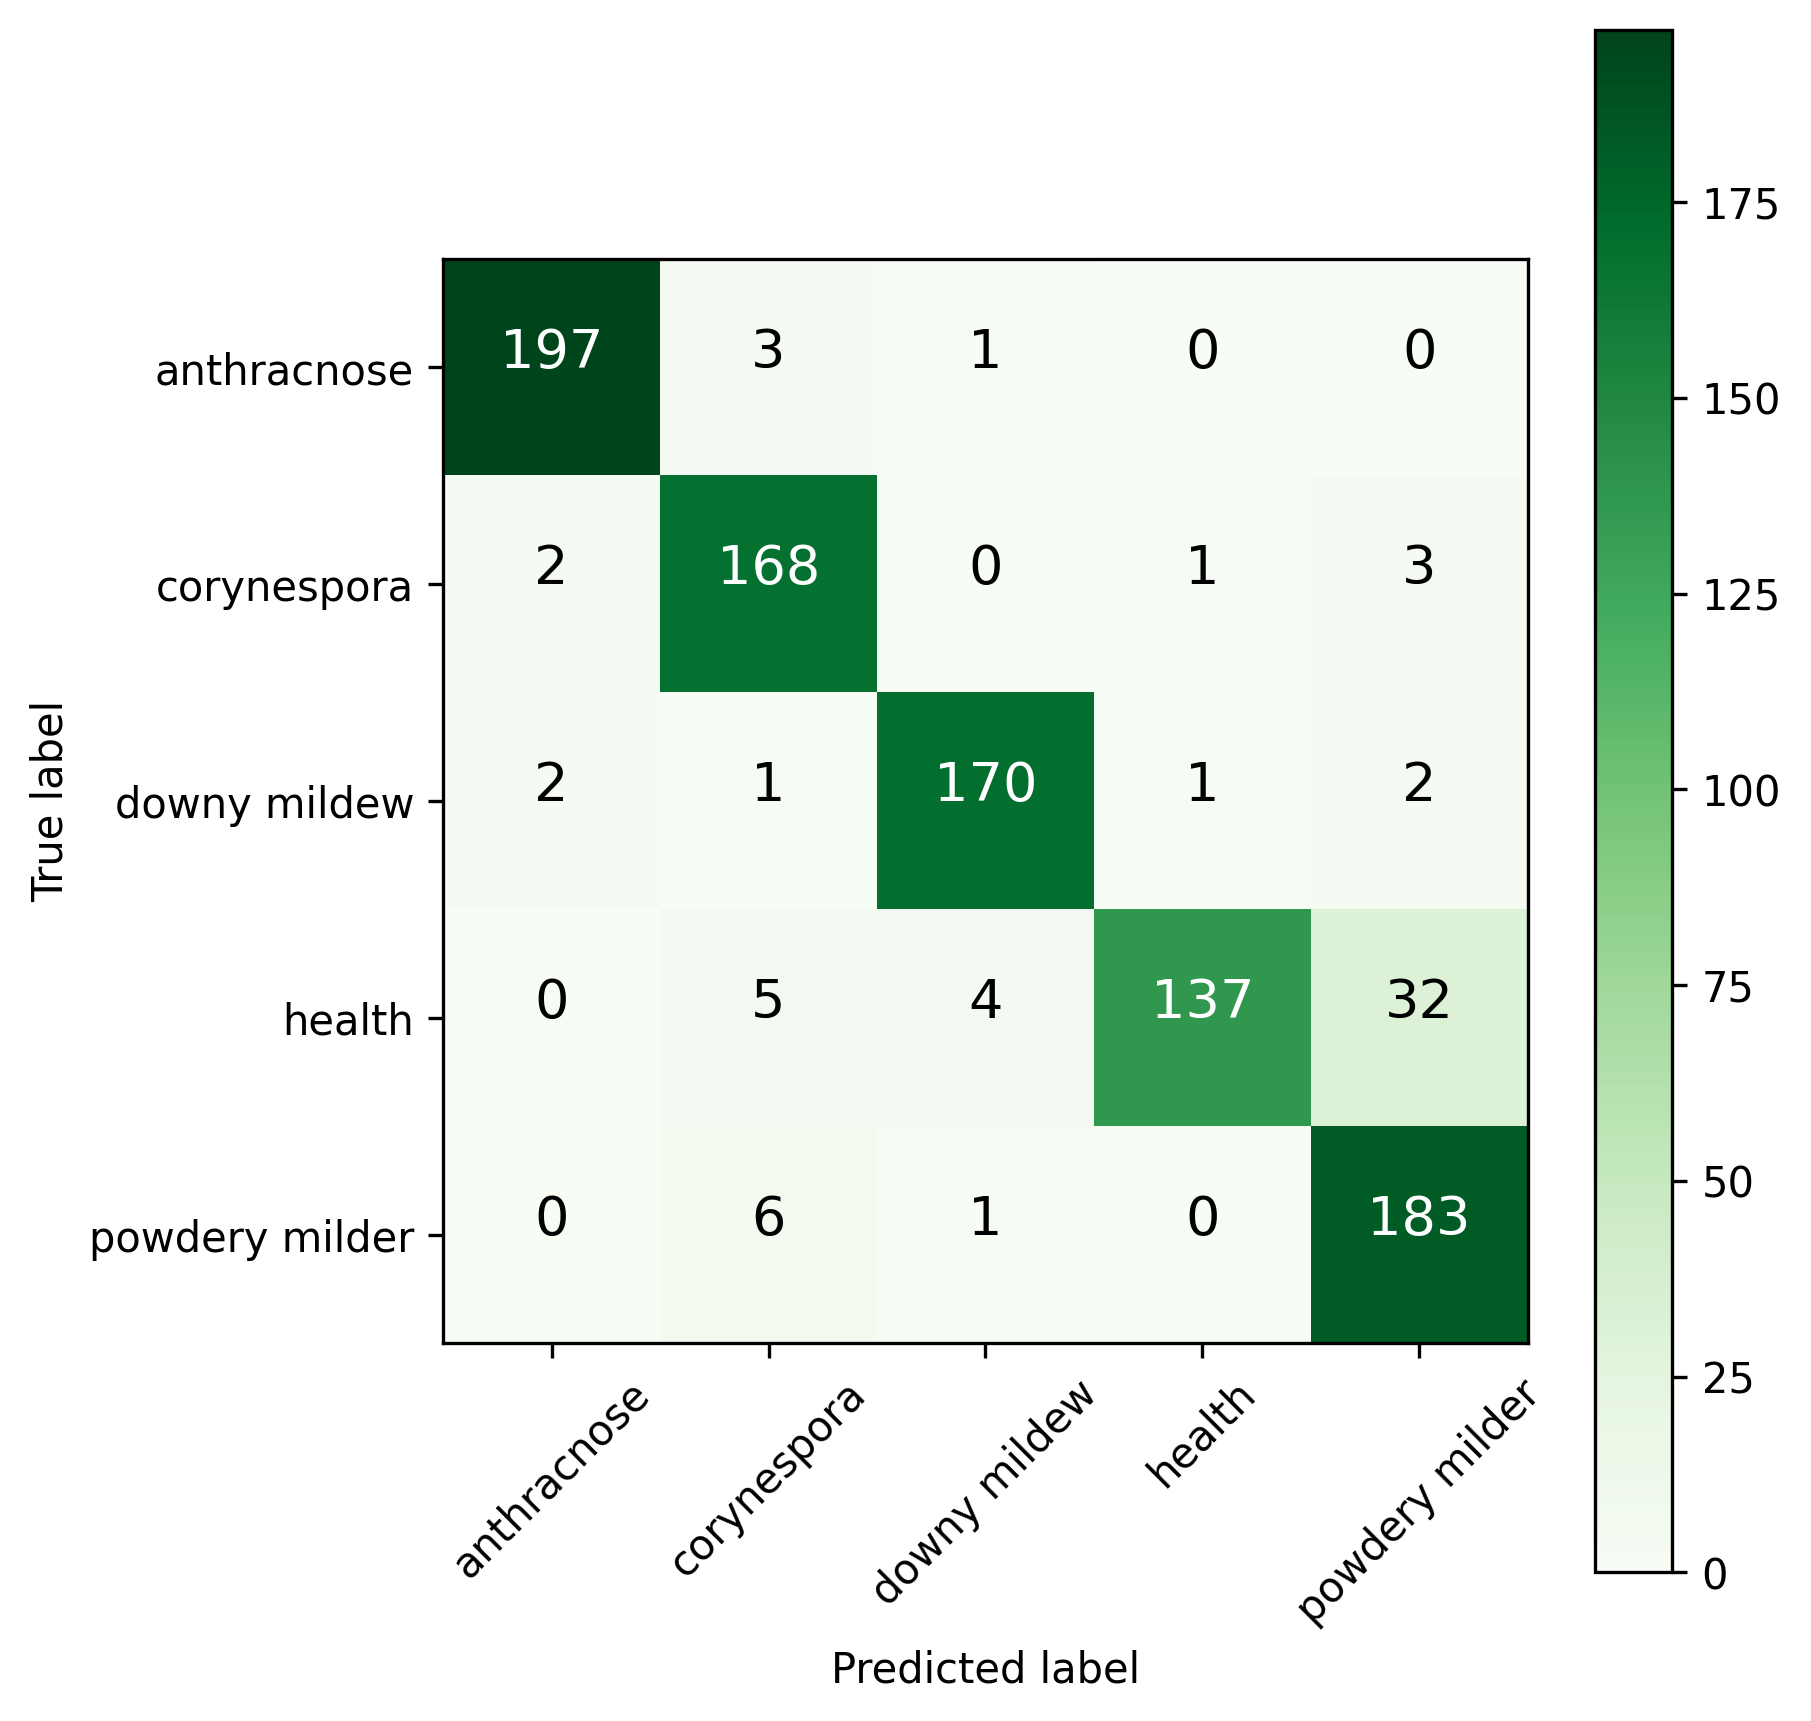

./lib/data/health/2127.jpg true: tensor(3, device='cuda:0') predicted: tensor(4, device='cuda:0')
./lib/data/health/2197.jpg true: tensor(3, device='cuda:0') predicted: tensor(2, device='cuda:0')
./lib/data/health/2052.jpg true: tensor(3, device='cuda:0') predicted: tensor(4, device='cuda:0')
./lib/data/anthracnose/2947.jpg true: tensor(0, device='cuda:0') predicted: tensor(1, device='cuda:0')
./lib/data/powdery_mildew/0951.jpg true: tensor(4, device='cuda:0') predicted: tensor(1, device='cuda:0')
./lib/data/health/2213.jpg true: tensor(3, device='cuda:0') predicted: tensor(4, device='cuda:0')
./lib/data/powdery_mildew/0235.jpg true: tensor(4, device='cuda:0') predicted: tensor(1, device='cuda:0')
./lib/data/health/1250.jpg true: tensor(3, device='cuda:0') predicted: tensor(4, device='cuda:0')
./lib/data/health/2272.jpg true: tensor(3, device='cuda:0') predicted: tensor(4, device='cuda:0')
./lib/data/downy_mildew/1802.jpg true: tensor(2, device='cuda:0') predicted: tensor(3, device='cu

[{'valid_loss': 0.20844988524913788,
  'valid_acc': 0.9442176818847656,
  'test_loss': 0.22075675427913666,
  'test_acc': 0.9303590655326843}]

In [7]:
model = CucumberModel()
# trainer = pl.Trainer(gpus=device,fast_dev_run=1) #set fast_dev_run=True or int to debug
trainer = pl.Trainer(gpus=device, max_epochs=num_epochs, progress_bar_refresh_rate=60)
trainer.fit(model, train_loader, valid_loader)
trainer.test(test_dataloaders=test_loader)